In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from matplotlib import rcParams
%pip install pyforest
import pyforest



Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [106]:
df = pd.read_csv('/Users/vivianmedina/Downloads/heart.csv')
df.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Cerca de 17,9 milhões de mortes por doenças cardiovasculares são registradas todos os anos, sendo a causa número um de mortes no mundo (31% do total). Este conjunto de dados possui 11 características que podem ser usadas para prever uma possível doença cardíaca. Como o diagnóstico precoce pode ajudar nos tratamentos, modelos de machine learning podem ser úteis e de grande ajuda.

In [107]:
print("Existem", df.shape[0], "linhas e", df.shape[1], "colunas no dataset.")

Existem 918 linhas e 12 colunas no dataset.


In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [109]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


In [110]:
#valores únicos por feature

for col in df.select_dtypes(include=[np.number]).columns:
  print(f"{col} tem {df[col].nunique()} valores únicos")

Age tem 50 valores únicos
RestingBP tem 67 valores únicos
Cholesterol tem 222 valores únicos
FastingBS tem 2 valores únicos
MaxHR tem 119 valores únicos
Oldpeak tem 53 valores únicos
HeartDisease tem 2 valores únicos


In [111]:
df.duplicated().value_counts()

False    918
dtype: int64

1    508
0    410
Name: HeartDisease, dtype: int64


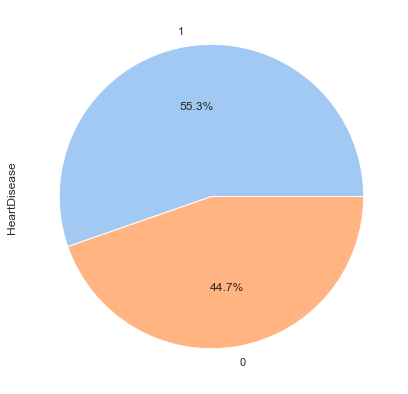

In [112]:
print(df["HeartDisease"].value_counts())
df["HeartDisease"].value_counts().plot(kind="pie", autopct='%1.1f%%', figsize=(7,7));

Percentual de doença cardíaca: % 55.34 -> (508 casos de doença cardíaca)


Percentual de sem doença cardíaca: % 44.66 -> (410 casos para sem doença cardíaca)

In [113]:
df[df['HeartDisease']==0].describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='RdPu')

,count,mean,std,min,25%,50%,75%,max
Age,410.000000,50.551220,9.444915,28.000000,43.000000,51.000000,57.000000,76.000000
RestingBP,410.000000,130.180488,16.499585,80.000000,120.000000,130.000000,140.000000,190.000000
Cholesterol,410.000000,227.121951,74.634659,0.000000,197.250000,227.000000,266.750000,564.000000
FastingBS,410.000000,0.107317,0.309894,0.000000,0.000000,0.000000,0.000000,1.000000
MaxHR,410.000000,148.151220,23.288067,69.000000,134.000000,150.000000,165.000000,202.000000
Oldpeak,410.000000,0.408049,0.699709,-1.100000,0.000000,0.000000,0.600000,4.200000
HeartDisease,410.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [114]:
df[df['HeartDisease']==1].describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='RdPu')

,count,mean,std,min,25%,50%,75%,max
Age,508.000000,55.899606,8.727056,31.000000,51.000000,57.000000,62.000000,77.000000
RestingBP,508.000000,134.185039,19.828685,0.000000,120.000000,132.000000,145.000000,200.000000
Cholesterol,508.000000,175.940945,126.391398,0.000000,0.000000,217.000000,267.000000,603.000000
FastingBS,508.000000,0.334646,0.472332,0.000000,0.000000,0.000000,1.000000,1.000000
MaxHR,508.000000,127.655512,23.386923,60.000000,112.000000,126.000000,144.250000,195.000000
Oldpeak,508.000000,1.274213,1.151872,-2.600000,0.000000,1.200000,2.000000,6.200000
HeartDisease,508.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0.5, 1.0, 'Correlation Plot')

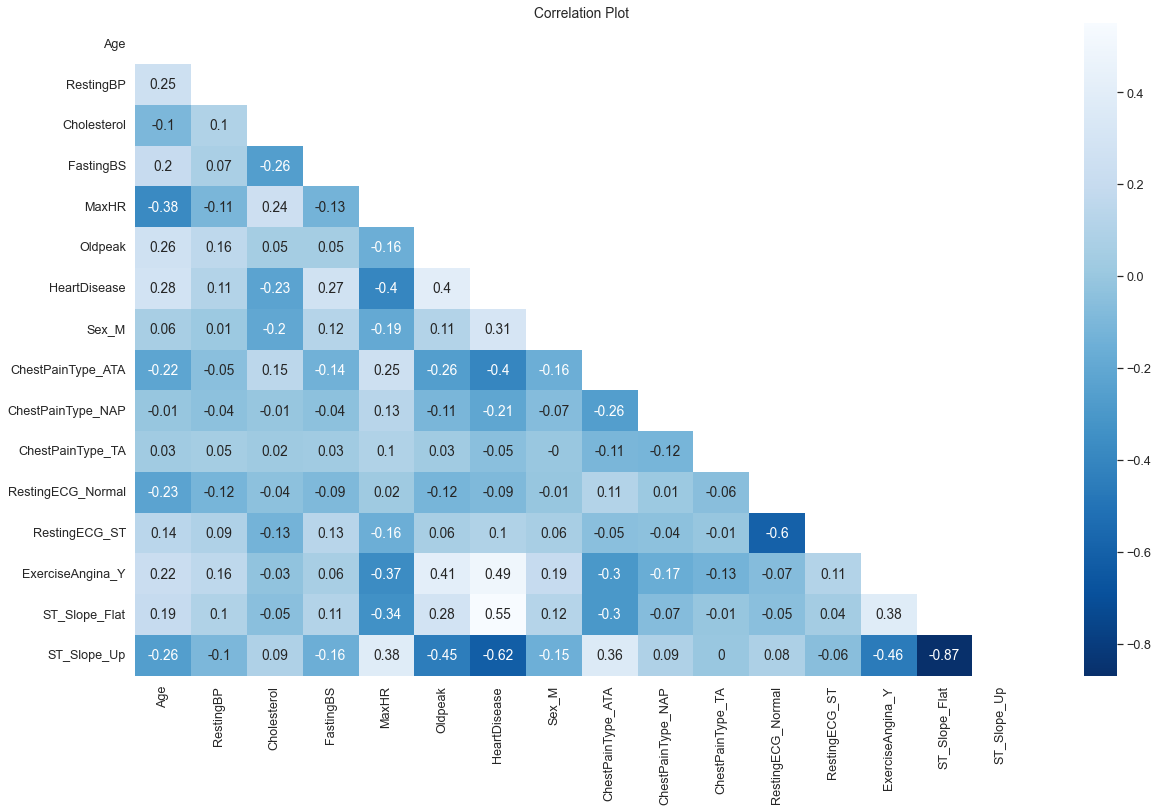

In [188]:
heart_df = pd.get_dummies(df,drop_first=True)
corr=heart_df.corr().round(2)

sns.set(font_scale=1.15)
plt.figure(figsize=(20, 12))
sns.set_palette("bright")
sns.set_style("white")
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,annot=True,cmap='Blues_r',mask=mask,cbar=True)
plt.title('Correlation Plot')

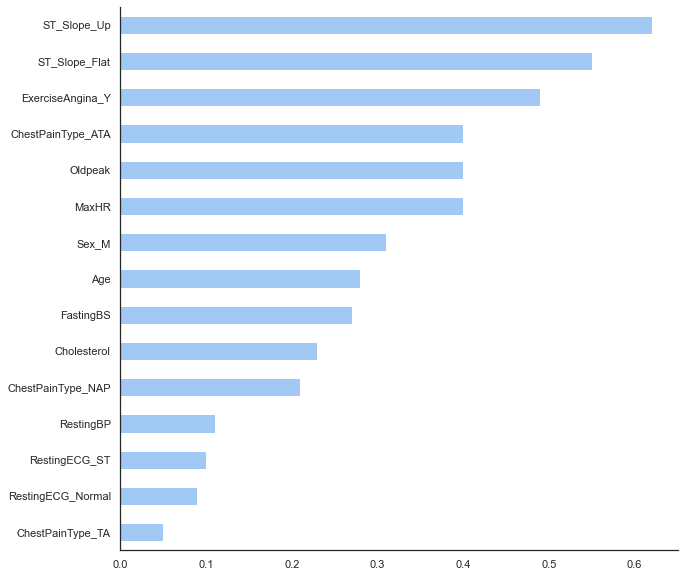

In [117]:
#Ordenando as maiores correlações com 'HeartDisease'
sns.set(font_scale=1)
plt.figure(figsize=(10, 10))
sns.set_style("white")
sns.set_palette("pastel")
abs(corr['HeartDisease']).sort_values()[:-1].plot.barh()
plt.gca().set_facecolor('#FFFFFF')
sns.despine()

A correlação entre heart disease e ST_Slope_Up e ST_Slope_Flat é alta

In [29]:
numerical = df.drop(['HeartDisease'], axis=1).select_dtypes('number').columns

categorical = df.select_dtypes('object').columns

print(f'Colunas numéricas:  {df[numerical].columns}')
print('\n')
print(f'Colunas categóricas: {df[categorical].columns}')

Colunas numéricas:  Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'], dtype='object')


Colunas categóricas: Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')


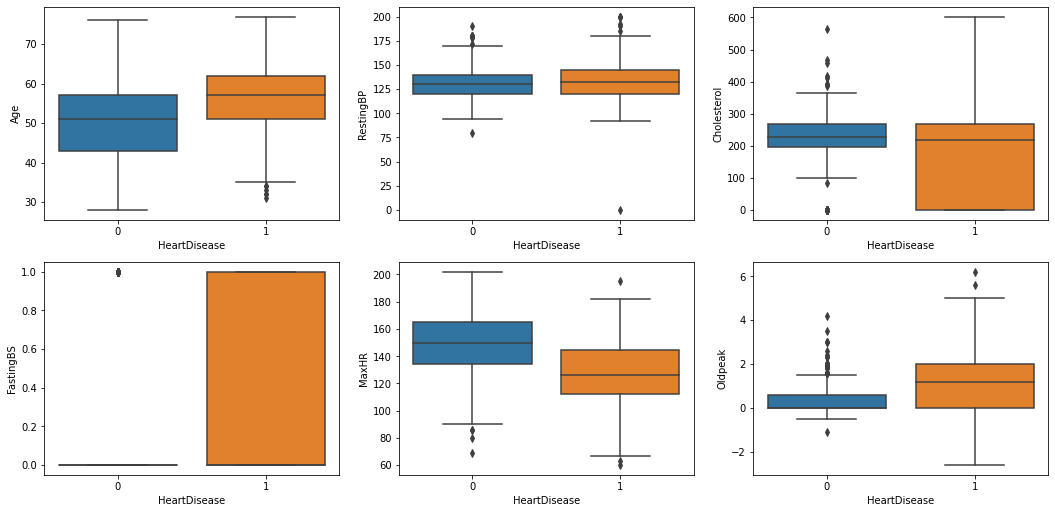

In [32]:
index = 0
plt.figure(figsize=(18,18))
for feature in numerical:
    if feature != "HeartDisease":
        index += 1
        plt.subplot(4, 3, index)
        sns.boxplot(x='HeartDisease', y=feature, data=df)

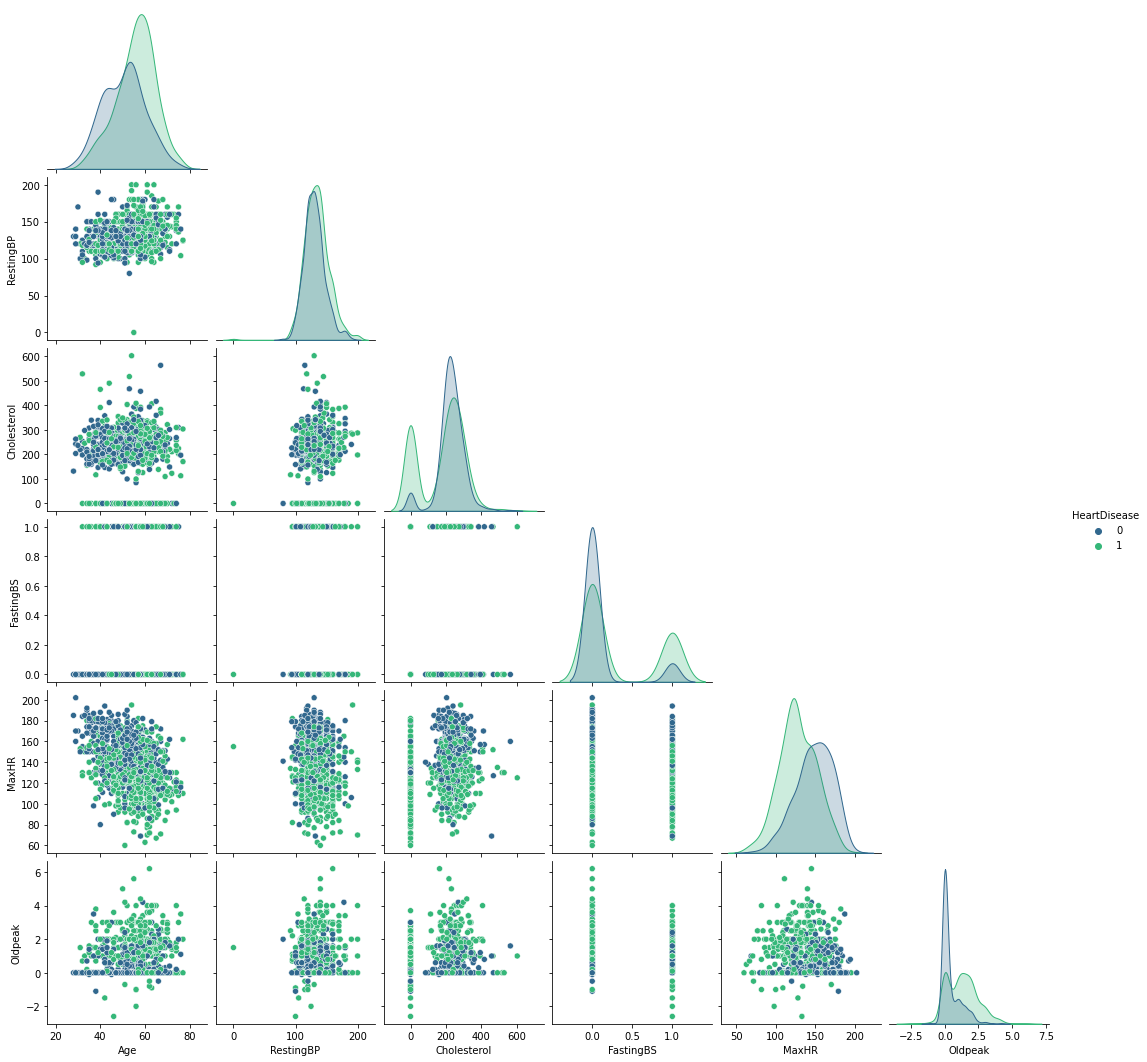

In [38]:
sns.pairplot(df, hue="HeartDisease", palette="viridis", corner=True);

In [41]:
df[categorical].head().T

,0,1,2,3,4
Sex,M,F,M,F,M
ChestPainType,ATA,NAP,ATA,ASY,NAP
RestingECG,Normal,Normal,ST,Normal,Normal
ExerciseAngina,N,N,N,Y,N
ST_Slope,Up,Flat,Up,Flat,Up


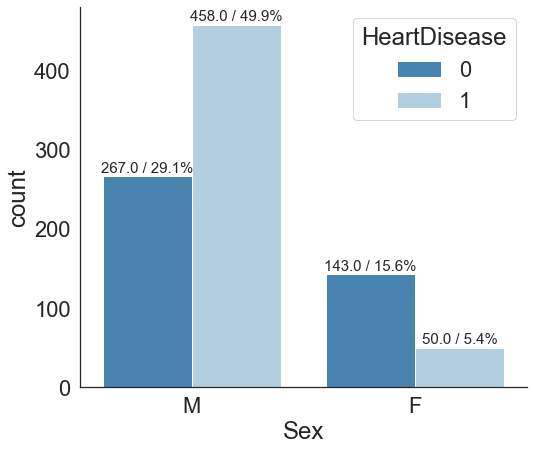

In [168]:
total_cnt = df['HeartDisease'].count()
plt.figure(figsize=(8,7))
sns.set(font_scale = 2)
sns.set_style("white")
ax = sns.countplot(data=df, x='Sex',hue='HeartDisease',palette='Blues_r')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 10, f'{height} / {height / total_cnt * 100:2.1f}%', va='center', ha='center', size=15)
sns.despine()

Os homens (49.9%) são mais acometidos por doenças cardíacas do que as mulheres (5.4%).

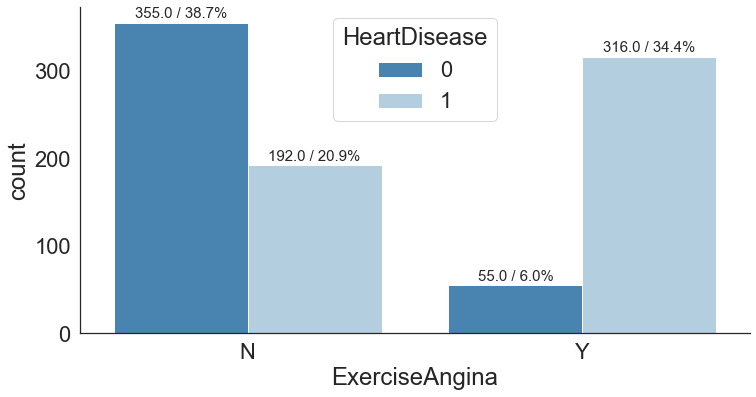

In [146]:
total_cnt = df['HeartDisease'].count()
plt.figure(figsize=(12,6))
sns.set(font_scale = 2)
sns.set_style("white")
ax = sns.countplot(data=df, x='ExerciseAngina',hue='HeartDisease',palette='Blues_r')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 10, f'{height} / {height / total_cnt * 100:2.1f}%', va='center', ha='center', size=15)
sns.despine()

Geralmente, quando angina induzida por exercício está presente, doenças cardíacas são diagnosticadas.

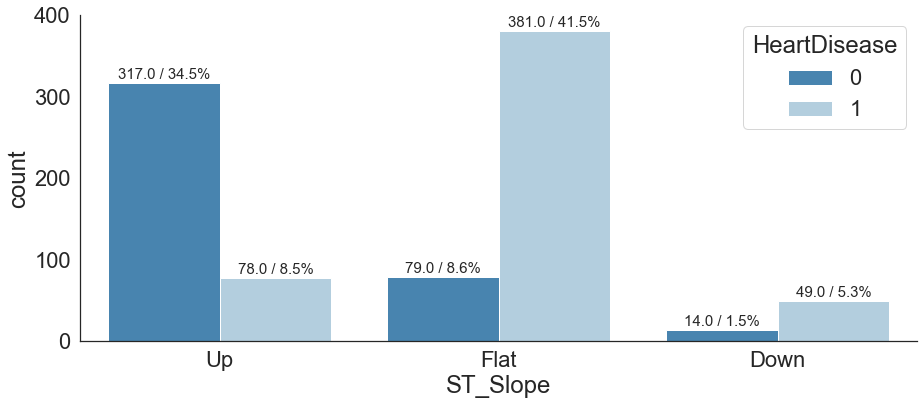

In [149]:
total_cnt = df['HeartDisease'].count()
plt.figure(figsize=(15,6))
sns.set(font_scale = 2)
sns.set_style("white")
ax = sns.countplot(data=df, x='ST_Slope',hue='HeartDisease',palette='Blues_r')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 10, f'{height} / {height / total_cnt * 100:2.1f}%', va='center', ha='center', size=15)
sns.despine()


Se ST_Slope for Flat, Na maioria das vezes é julgado como doença cardíaca.

In [158]:
X = heart_df.drop(["HeartDisease"], axis=1)
y = heart_df["HeartDisease"]

In [172]:
from sklearn.model_selection import train_test_split
X_treino, X_teste, y_treino, y_teste = train_test_split(heart_df[['ST_Slope_Up','ExerciseAngina_Y']],heart_df['HeartDisease'] ,test_size=0.2)
X_treino.head(2)


,ST_Slope_Up,ExerciseAngina_Y
319,1,0
844,0,0


In [173]:
import statsmodels.api as sm
Xs = sm.add_constant(X_treino)
rl0 = sm.Logit(y_treino, Xs).fit()
rl0.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.452904
         Iterations 6


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,0.660718,0.151857,4.350924,1.355649e-05,0.363084,0.958352
ST_Slope_Up,-2.358240,0.198344,-11.889639,1.339848e-32,-2.746987,-1.969493
ExerciseAngina_Y,1.613989,0.215270,7.497503,6.504503e-14,1.192067,2.035910


<AxesSubplot: xlabel='ST_Slope_Up', ylabel='HeartDisease'>

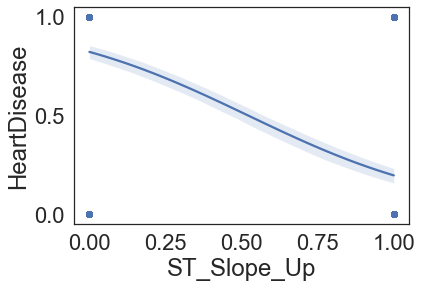

In [174]:
import seaborn as sns
sns.regplot(x="ST_Slope_Up", y="HeartDisease", data=heart_df,logistic=True)

<AxesSubplot: xlabel='ExerciseAngina_Y', ylabel='HeartDisease'>

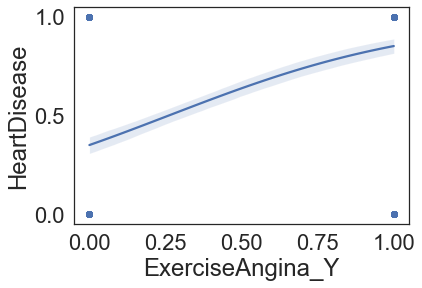

In [180]:
import seaborn as sns
sns.regplot(x="ExerciseAngina_Y", y="HeartDisease", data=heart_df,logistic=True)

In [181]:
import sklearn.linear_model as skl_lm
rlog = skl_lm.LogisticRegression()
rlog.fit(X_treino,y_treino)
acuracia_treino= rlog.score(X_treino,y_treino)*100
acuracia_treino

80.51771117166211

In [182]:
from sklearn.metrics import accuracy_score
prev_teste = rlog.predict(X_teste)
acuracia_teste = accuracy_score(y_teste,prev_teste)
acuracia_teste 

0.8478260869565217

[[61 13]
 [15 95]]


<AxesSubplot: >

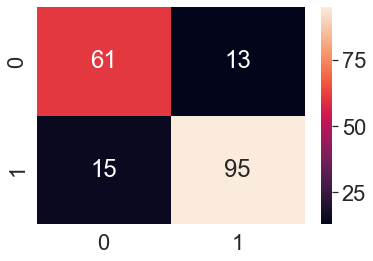

In [183]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_teste , prev_teste)
print(cm)
sns.heatmap(cm, annot=True)

In [184]:
from sklearn.metrics import classification_report
print(classification_report(y_teste , prev_teste))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81        74
           1       0.88      0.86      0.87       110

    accuracy                           0.85       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.85      0.85      0.85       184



O modelo apresentou 80% de acuracia no treino e 84% no teste.   